In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from joblib import dump, load

# Data preparing

In [65]:
cancer_data = pd.read_csv('../../data/cancer_data_v4.csv')
cancer_data.drop(['WBC', 'EO%', 'EO', 'GLO', 'NEUT%', 'HCT', 'TCH','TBIL', 'IBIL', 'LDH-L'], axis=1, inplace=True)
for fea in cancer_data.columns[6:]:
    median = cancer_data.groupby(['Age_group', 'A=male B=female'])[fea].median()
    cancer_data.set_index(['Age_group', 'A=male B=female'], inplace=True)
    cancer_data[fea].fillna(median, inplace=True)
    cancer_data.reset_index(inplace=True)
cancer_data['A=Case, B=Control'] = cancer_data['A=Case, B=Control'].apply(lambda x: 1 if x=='A' else 0)
X_train, X_test, y_train, y_test = train_test_split(cancer_data.drop(['Origin','Age_group','A=male B=female','ID', 'A=Case, B=Control', 'Pattern'], axis=1), cancer_data['A=Case, B=Control'], test_size=0.3, random_state=0)

# Random Forest

In [66]:
rf = load('../model/rf_clf')
y_pred = rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

rf_prob = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
rf_auc = auc(rf_fpr, rf_tpr)

print("ACC:",accuracy_score(y_test, y_pred))
print("REC:",recall_score(y_test, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",rf_auc)
importances = pd.DataFrame(rf.feature_importances_, columns = ['rf_importance'], index=X_train.columns).sort_values(by='rf_importance', ascending=False)

ACC: 0.9414029084687767
REC: 0.9325657894736842
SPC: 0.9509803921568627
AUC: 0.9844820105075522


# XGBoost

In [67]:
xgb = load('../model/xgb_clf')
y_pred = xgb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

xgb_prob = xgb.predict_proba(X_test)[:,1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
xgb_auc = auc(xgb_fpr, xgb_tpr)

print("ACC:",accuracy_score(y_test, y_pred))
print("REC:",recall_score(y_test, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",xgb_auc)
importances['xgb_importance'] = pd.DataFrame(xgb.feature_importances_, index=X_train.columns)

ACC: 0.9820359281437125
REC: 0.9720394736842105
SPC: 0.9928698752228164
AUC: 0.9973899697438784


# ROC & AUC

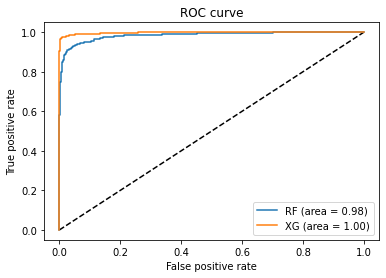

In [26]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc)
plt.plot(xgb_fpr, xgb_tpr, label='XG (area = %0.2f)' % xgb_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Data preparing2

In [88]:
cancer_data = pd.read_csv('../../data/cancer_data_v4.csv')
cancer_data.drop(['WBC', 'EO%', 'EO', 'GLO', 'NEUT%', 'HCT', 'TCH','TBIL', 'IBIL', 'LDH-L'], axis=1, inplace=True)
for fea in cancer_data.columns[6:]:
    median = cancer_data.groupby(['Age_group', 'A=male B=female'])[fea].median()
    cancer_data.set_index(['Age_group', 'A=male B=female'], inplace=True)
    cancer_data[fea].fillna(median, inplace=True)
    cancer_data.reset_index(inplace=True)
cancer_data['A=Case, B=Control'] = cancer_data['A=Case, B=Control'].apply(lambda x: 1 if x=='A' else 0)

group_b = cancer_data[cancer_data['Origin']=='B']
group_c = cancer_data[cancer_data['Origin']=='C'].sample(n=212,random_state=0)

new = pd.concat([group_b,group_c], axis=0).sample(frac=1,random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(new.drop(['Origin','Age_group','A=male B=female','ID', 'A=Case, B=Control', 'Pattern'], axis=1), new['A=Case, B=Control'], test_size=0.3, random_state=0)

In [89]:
X_train2

,Age,Smoke,MCV,ALT,AST:ALT,GLU,BUN,Cr,RBC,HGB,...,Cystatin-C,UA,TG,HDL-C,LDL-C,ALP,GGT,CK,HBDH,T-CEA
4539,59,0.0,83.5,23.0,0.91,5.97,4.50,67.0,5.70,147.0,...,0.88,404.0,1.11,1.50,3.84,50.0,23.0,119.0,101.0,1.44
1937,53,300.0,90.7,33.0,0.88,5.29,4.55,93.3,4.83,144.0,...,0.83,293.0,3.82,0.87,2.49,56.0,46.0,162.0,110.0,0.88
5451,47,0.0,92.5,19.0,1.16,5.89,3.90,74.0,5.59,169.0,...,0.82,271.0,1.36,1.34,4.73,79.0,17.0,116.0,157.0,1.08
5364,48,0.0,93.4,12.0,0.83,4.57,4.70,80.0,5.33,164.0,...,0.91,374.0,1.78,1.49,3.83,48.0,21.0,77.0,114.0,0.65
4975,74,0.0,93.1,14.0,1.36,4.87,4.90,82.0,4.51,135.0,...,1.16,390.0,1.41,0.84,1.55,98.0,26.0,107.0,141.0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7621,51,900.0,93.1,29.0,0.76,4.78,4.60,81.0,5.53,173.0,...,0.95,499.0,4.61,0.97,2.82,91.0,23.0,100.0,136.0,1.43
7060,66,0.0,87.3,7.0,1.17,5.94,4.40,45.0,4.81,136.0,...,0.74,289.0,1.27,1.54,3.69,93.0,11.0,148.0,177.0,1.47
7241,65,0.0,87.6,18.0,1.33,7.63,9.70,121.0,4.99,143.0,...,0.90,424.0,0.57,1.44,2.15,58.0,8.0,100.0,154.0,7.05
6362,65,0.0,98.3,14.0,1.00,4.22,7.10,89.0,4.64,148.0,...,1.21,360.0,1.16,1.70,1.64,68.0,28.0,48.0,143.0,2.82


## RF

In [90]:
rf = load('../model/rf_clf_mini')
y_pred = rf.predict(X_test2)
tn, fp, fn, tp = confusion_matrix(y_test2, y_pred).ravel()

rf_prob = rf.predict_proba(X_test2)[:,1]
rf_fpr2, rf_tpr2, _ = roc_curve(y_test2, rf_prob)
rf_auc2 = auc(rf_fpr2, rf_tpr2)

print("ACC:",accuracy_score(y_test2, y_pred))
print("REC:",recall_score(y_test2, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",rf_auc2)
importances['rf_mini_importance'] = pd.DataFrame(rf.feature_importances_, index=X_train2.columns)

ACC: 0.640625
REC: 0.5373134328358209
SPC: 0.7540983606557377
AUC: 0.7122583802299975


## XGB

In [91]:
xgb = load('../model/xgb_clf_mini')
y_pred = xgb.predict(X_test2)
tn, fp, fn, tp = confusion_matrix(y_test2, y_pred).ravel()

xgb_prob = xgb.predict_proba(X_test2)[:,1]
xgb_fpr2, xgb_tpr2, _ = roc_curve(y_test2, xgb_prob)
xgb_auc2 = auc(xgb_fpr2, xgb_tpr2)

print("ACC:",accuracy_score(y_test2, y_pred))
print("REC:",recall_score(y_test2, y_pred))
print("SPC:",tn/(tn+fp))
print("AUC:",xgb_auc2)
importances['xgb_mini_importance'] = pd.DataFrame(xgb.feature_importances_, index=X_train2.columns)

ACC: 0.6640625
REC: 0.5970149253731343
SPC: 0.7377049180327869
AUC: 0.7700024467824811


In [92]:
importances.to_csv('../../data/featureImportance.csv')

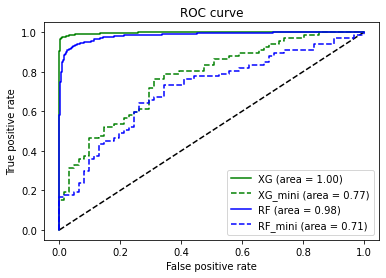

In [93]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(xgb_fpr, xgb_tpr, label='XG (area = %0.2f)' % xgb_auc, color='g')
plt.plot(xgb_fpr2, xgb_tpr2, label='XG_mini (area = %0.2f)' % xgb_auc2, color='g', linestyle="--")
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_auc, color='b')
plt.plot(rf_fpr2, rf_tpr2, label='RF_mini (area = %0.2f)' % rf_auc2, color='b', linestyle="--")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()